<h1><b><p style="background-image: url(https://i.postimg.cc/0Qwf8YX6/2927262.jpg);font-family:camtasia;font-size:110%;color:white;text-align:center;border-radius:15px 50px; padding:7px; border:solid 2px #09375b; box-shadow: 10px 10px 10px #042b4c">Project Title: BBC News Classification Using Bert</p></b></h1>

### Tabel of Contents:

* [Import Libraries](#1)
* [Load Dataset](#2)
* [Bert Model](#4)
* [Evaluation](#3)
* [Predictive for Test](#8)
* [Like this? Upvote and comment! 🌊 End](#6)

**<a id="1"></a>
<h1><b><p style="background-image: url(https://i.postimg.cc/0Qwf8YX6/2927262.jpg);font-family:camtasia;font-size:110%;color:white;text-align:center;border-radius:15px 50px; padding:7px; border:solid 2px #09375b; box-shadow: 10px 10px 10px #042b4c">Import Libraries</p></b></h1>
<a class="btn" href="#home">Tabel of Contents</a>

In [1]:
!pip install --upgrade transformers wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.1/44.1 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.0/10.0 MB 86.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.1/16.1 MB 94.0 MB/s eta 0:00:00
  Attempting uninstall: wandb
    Found existing installation: wandb 0.18.3
    Uninstalling wandb-0.18.3:
      Successfully uninstalled wandb-0.18.3
  Attempting uninstall: transformers
    Found existing installation: transformers 4.45.1
    Uninstalling transformers-4.45.1:
      Successfully uninstalled transformers-4.45.1


In [2]:
import pandas as pd
import re
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report,accuracy_score
import numpy as np
import torch 
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import AutoTokenizer, AutoModelForSequenceClassification,DataCollatorWithPadding
from transformers import Trainer, TrainingArguments
import transformers
from datasets import Dataset, DatasetDict
from sklearn.preprocessing import LabelEncoder
from huggingface_hub import login
from huggingface_hub import Repository
import wandb
wandb.init(mode = "disabled") 
import warnings
warnings.filterwarnings('ignore')

**<a id="2"></a>
<h1><b><p style="background-image: url(https://i.postimg.cc/0Qwf8YX6/2927262.jpg);font-family:camtasia;font-size:110%;color:white;text-align:center;border-radius:15px 50px; padding:7px; border:solid 2px #09375b; box-shadow: 10px 10px 10px #042b4c">Load Dataset</p></b></h1>
<a class="btn" href="#home">Tabel of Contents</a>

In [3]:
data = pd.read_csv('/kaggle/input/news-categories-dataset/bbc-text.csv')
data.columns = ['labels','text'] 
data.head()

,labels,text
0,tech,tv future in the hands of viewers with home th...
1,business,worldcom boss left books alone former worldc...
2,sport,tigers wary of farrell gamble leicester say ...
3,sport,yeading face newcastle in fa cup premiership s...
4,entertainment,ocean s twelve raids box office ocean s twelve...


In [4]:
### Shape of Dataset
print(f"The dataset has {data.shape[0]} Rows and {data.shape[1]} columns")

The dataset has 2225 Rows and 2 columns


In [5]:
### Info of Dataset
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2225 entries, 0 to 2224
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   labels  2225 non-null   object
 1   text    2225 non-null   object
dtypes: object(2)
memory usage: 34.9+ KB


In [6]:
data.isna().sum()

labels    0
text      0
dtype: int64

In [7]:
# NLTK English stopwords
english_stopwords = set(stopwords.words('english'))

def clean_bbc_news_text(text):
    """
    Cleans a given text by:
    - Removing HTML tags
    - Removing special characters and punctuation
    - Removing digits
    - Converting text to lowercase
    - Removing NLTK stopwords
    
    Args:
        text (str): The text to be cleaned.
    
    Returns:
        str: The cleaned text.
    """
    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)
    
    # Remove special characters and punctuation (retain spaces)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    
    # Remove digits
    text = re.sub(r'\d+', '', text)
    
    # Convert text to lowercase
    text = text.lower()
    
    # Tokenize and remove stopwords
    words = text.split()
    words = [word for word in words if word not in english_stopwords]
    
    # Join words back into a single string
    cleaned_text = ' '.join(words)
    
    return cleaned_text

In [8]:
data.text = data.text.apply(clean_bbc_news_text)
data.head()

,labels,text
0,tech,tv future hands viewers home theatre systems p...
1,business,worldcom boss left books alone former worldcom...
2,sport,tigers wary farrell gamble leicester say rushe...
3,sport,yeading face newcastle fa cup premiership side...
4,entertainment,ocean twelve raids box office ocean twelve cri...


In [9]:
encoder = LabelEncoder()
data.labels = encoder.fit_transform(data.labels)
data.head()

,labels,text
0,4,tv future hands viewers home theatre systems p...
1,0,worldcom boss left books alone former worldcom...
2,3,tigers wary farrell gamble leicester say rushe...
3,3,yeading face newcastle fa cup premiership side...
4,1,ocean twelve raids box office ocean twelve cri...


In [10]:
dataset = Dataset.from_pandas(data)
dataset

Dataset({
    features: ['labels', 'text'],
    num_rows: 2225
})

**<a id="4"></a>
<h1><b><p style="background-image: url(https://i.postimg.cc/0Qwf8YX6/2927262.jpg);font-family:camtasia;font-size:110%;color:white;text-align:center;border-radius:15px 50px; padding:7px; border:solid 2px #09375b; box-shadow: 10px 10px 10px #042b4c">Bert Model</p></b></h1>
<a class="btn" href="#home">Tabel of Contents</a>

In [11]:
model_name = "bert-base-uncased" 
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=len(data.labels.unique()))

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [12]:
def preprocess_function(examples):
    return tokenizer(examples['text'], padding="max_length", truncation=True)
encoded_dataset = dataset.map(preprocess_function, batched=True)

Map:   0%|          | 0/2225 [00:00<?, ? examples/s]

In [13]:
dataset_size = len(encoded_dataset)
train_size = int(0.7 * dataset_size)  # 30% for training
valid_size = int(0.1 * dataset_size)  # 1% for validation
test_size = int(0.2 * dataset_size)   # 1% for testing

shuffled_dataset = encoded_dataset.shuffle(seed=42)

# Select 30% for training
train_dataset = shuffled_dataset.select(range(train_size))

# Select 1% for validation (next segment after training set)
valid_dataset = shuffled_dataset.select(range(train_size, train_size + valid_size))

# Select 1% for testing (remaining segment)
test_dataset = shuffled_dataset.select(range(train_size + valid_size, train_size + valid_size + test_size))

In [14]:
train_dataset

Dataset({
    features: ['labels', 'text', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 1557
})

In [15]:
valid_dataset

Dataset({
    features: ['labels', 'text', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 222
})

In [16]:
test_dataset

Dataset({
    features: ['labels', 'text', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 445
})

In [17]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = torch.argmax(torch.tensor(predictions), dim=1)
    accuracy = accuracy_score(labels, predictions)
    return {"accuracy": accuracy}
training_args = TrainingArguments(
    output_dir="./Finetuning_BERT_BBCNews_output",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=10,
    weight_decay=0.01,
)
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=valid_dataset,
    compute_metrics=compute_metrics,
)

In [18]:
trainer.train()
trainer.save_model()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.121797,0.972973
2,No log,0.094472,0.981982
3,0.194100,0.095712,0.981982
4,0.194100,0.106264,0.981982
5,0.194100,0.103249,0.986486
6,0.014100,0.119237,0.977477
7,0.014100,0.114086,0.981982
8,0.003100,0.136472,0.977477
9,0.003100,0.147614,0.977477
10,0.003100,0.148831,0.977477


In [19]:
tokenizer.save_pretrained(training_args.output_dir)

('./Finetuning_BERT_BBCNews_output/tokenizer_config.json',
 './Finetuning_BERT_BBCNews_output/special_tokens_map.json',
 './Finetuning_BERT_BBCNews_output/vocab.txt',
 './Finetuning_BERT_BBCNews_output/added_tokens.json',
 './Finetuning_BERT_BBCNews_output/tokenizer.json')

In [ ]:
login(token="HUGGINGFACE_TOKEN")

The token has not been saved to the git credentials helper. Pass `add_to_git_credential=True` in this function directly or `--add-to-git-credential` if using via `huggingface-cli` if you want to set the git credential as well.
Token is valid (permission: fineGrained).
Your token has been saved to /root/.cache/huggingface/token
Login successful


In [21]:
repo_name = "ahmed792002/Finetuning_BERT_BBCNews"
trainer.push_to_hub(repo_name)
tokenizer.push_to_hub(repo_name)

training_args.bin:   0%|          | 0.00/5.30k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

events.out.tfevents.1732789257.1298a30d7219.23.0:   0%|          | 0.00/9.54k [00:00<?, ?B/s]

Upload 3 LFS files:   0%|          | 0/3 [00:00<?, ?it/s]

README.md:   0%|          | 0.00/2.01k [00:00<?, ?B/s]

No files have been modified since last commit. Skipping to prevent empty commit.


CommitInfo(commit_url='https://huggingface.co/ahmed792002/Finetuning_BERT_BBCNews/commit/c814ebfd6f330ad3fdbe11ee9e2e2349e10f83f6', commit_message='Upload tokenizer', commit_description='', oid='c814ebfd6f330ad3fdbe11ee9e2e2349e10f83f6', pr_url=None, repo_url=RepoUrl('https://huggingface.co/ahmed792002/Finetuning_BERT_BBCNews', endpoint='https://huggingface.co', repo_type='model', repo_id='ahmed792002/Finetuning_BERT_BBCNews'), pr_revision=None, pr_num=None)

**<a id="1"></a>
<h1><b><p style="background-image: url(https://i.postimg.cc/0Qwf8YX6/2927262.jpg);font-family:camtasia;font-size:110%;color:white;text-align:center;border-radius:15px 50px; padding:7px; border:solid 2px #09375b; box-shadow: 10px 10px 10px #042b4c">Evaluation</p></b></h1>
<a class="btn" href="#home">Tabel of Contents</a>

In [22]:
results = trainer.evaluate(test_dataset)
print("Evaluation results:", results)

Evaluation results: {'eval_loss': 0.13760891556739807, 'eval_accuracy': 0.9752808988764045, 'eval_runtime': 7.0123, 'eval_samples_per_second': 63.46, 'eval_steps_per_second': 7.986, 'epoch': 10.0}


In [23]:
y_pred_prob = trainer.predict(test_dataset).predictions
y_pred = np.argmax(y_pred_prob, axis=1)
y_test = np.array(test_dataset['labels'])

In [24]:
class_names = encoder.classes_
class_names

array(['business', 'entertainment', 'politics', 'sport', 'tech'],
      dtype=object)

Confusion Matrix is : 
 [[101   0   2   0   0]
 [  0  87   0   0   1]
 [  3   0  72   0   0]
 [  0   0   1 104   0]
 [  3   1   0   0  70]]


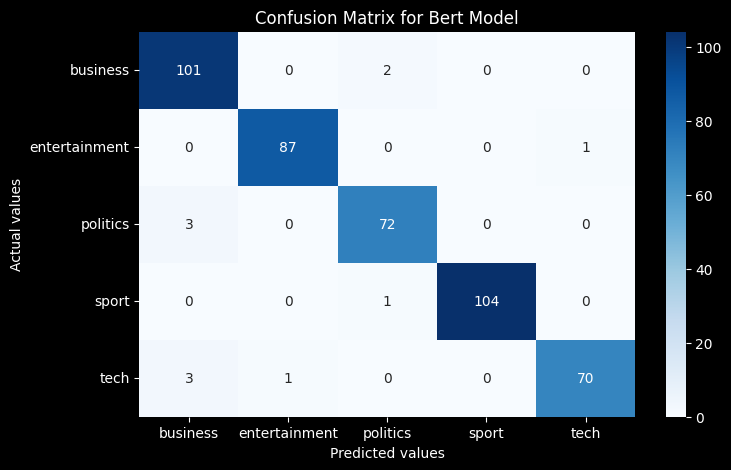

In [25]:
plt.style.use('dark_background')
### Check model
CM = confusion_matrix(y_test, y_pred)
print('Confusion Matrix is : \n', CM)
plt.figure(figsize=(8,5))
sns.heatmap(data=CM, annot=True,fmt='g', cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted values')
plt.ylabel('Actual values')
plt.title('Confusion Matrix for Bert Model')
plt.show()

In [26]:
ClassificationReport = classification_report(y_test, y_pred,target_names=class_names)
print('Classification Report is : ', ClassificationReport )

Classification Report is :                 precision    recall  f1-score   support

     business       0.94      0.98      0.96       103
entertainment       0.99      0.99      0.99        88
     politics       0.96      0.96      0.96        75
        sport       1.00      0.99      1.00       105
         tech       0.99      0.95      0.97        74

     accuracy                           0.98       445
    macro avg       0.98      0.97      0.97       445
 weighted avg       0.98      0.98      0.98       445



<a id="8"></a>
<h1><b><p style="background-image: url(https://i.postimg.cc/0Qwf8YX6/2927262.jpg);font-family:camtasia;font-size:110%;color:white;text-align:center;border-radius:15px 50px; padding:7px; border:solid 2px #09375b; box-shadow: 20px 10px 10px #042b4c">Predictive for Test</p></b></h1>

In [27]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
def Predictive(text):
    text = clean_bbc_news_text(text)
    token = tokenizer(
        text,
        truncation=True,
        padding="max_length",
        return_tensors="pt"
    ).to(device)
    model.eval()
    with torch.no_grad():
        logits = model(**token).logits
    prediction = logits.argmax(dim=1).item()
    return encoder.inverse_transform([prediction])[0]

In [28]:
test_sentence = "The stock market saw a significant increase today, with tech companies leading the way."
result = Predictive(test_sentence)
print(f"The predicted category is: {result}")

The predicted category is: business


In [29]:
test_sentence = "The national football team secured a thrilling victory in the championship final last night."
result = Predictive(test_sentence)
print(f"The predicted category is: {result}")

The predicted category is: sport


In [30]:
test_sentence = "The movie's release is set to break box office records this weekend, with fans eagerly awaiting the premiere."
result = Predictive(test_sentence)
print(f"The predicted category is: {result}")

The predicted category is: entertainment


<center><span style="font-family:Palatino; font-size:22px;"><i>Like this? <span style="color:#DC143C;">Upvote and Comment!</span> </i>🌊 End</span> </center>